In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats
import json

In [2]:
mylist=pd.read_csv("all_spus.txt", names=["spu"])
mylist=set(mylist.spu.unique())
len(mylist)

4845

In [3]:
prom=pd.read_csv("prom_spus.txt", names=["spu"])
prom=set(prom.spu.unique())
nprom=pd.read_csv("non_prom_spus.txt", names=["spu"])
nprom=set(nprom.spu.unique())

# PPI

## Read and clean data

In [ ]:
with open("7668.protein.physical.links.detailed.v11.5.txt") as f: # downloaded from STRING database, physical links, taxonomic ID 7668
  links = list(map(lambda x: x.strip().split(" "), f.readlines()))
  print(links[0])
  links = links[1:]

['protein1', 'protein2', 'experimental', 'database', 'textmining', 'combined_score']


In [ ]:
clean_links =[(_f, _t, (float(exp)+float(dat)) ) for _f, _t, exp, dat, tex, conf in links[:len(links)-1] ] # we don't care about textmining

In [ ]:
confs = np.array([conf for _,_,conf in clean_links])

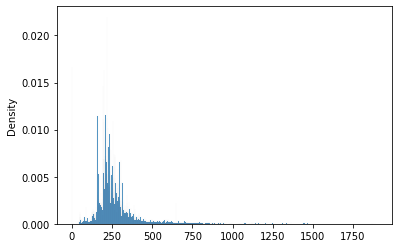

In [ ]:
sns.histplot(confs,stat="density")

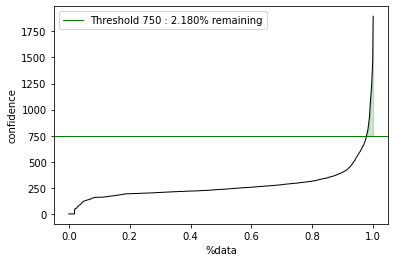

In [ ]:
thresh = 750

xs = np.linspace(0,1,len(confs))
plt.plot(xs,confs,
         lw=1,
         color="black")
plt.xlabel("%data")
plt.ylabel("confidence")
plt.axhline(thresh,
            label=f"Threshold {thresh} : {len(confs[confs > thresh])/len(confs)*100:.3f}% remaining",
            lw=1,
            color="green")
plt.fill_between(xs, confs, thresh, 
                 where=confs > thresh,
                 alpha=.2,
                 color="green")
plt.legend()

In [ ]:
adj = [(_from, _to, conf) for _from, _to, conf in clean_links if conf > thresh]

In [ ]:
adj = [(_from.split(".")[1], _to.split(".")[1]) for _from, _to, conf in clean_links if conf > thresh]

In [ ]:
adj = [(_from.split("-")[0], _to.split("-")[0]) for _from, _to in adj]

In [ ]:
def to_adjlist(adj):
    adj_list = defaultdict(list)
    for _from,_to in adj:
        adj_list[_from].append(_to)

    adj_list = dict(adj_list)
    return adj_list

In [ ]:
adj_list = to_adjlist(adj)

In [ ]:
len(adj_list)

5901

In [ ]:
with open('PPI_adjlist_th_750.json', 'w') as fp:
    json.dump(adj_list, fp)

Average degree 245.5099603567889


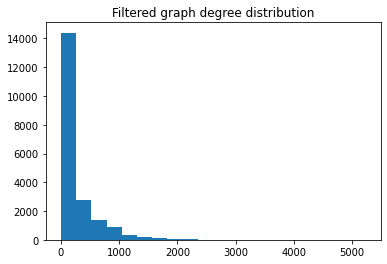

In [ ]:
out_edges = np.array([len(out) for node,out in adj_list.items()])
plt.hist(out_edges, bins=20)
plt.title("Filtered graph degree distribution")
print("Average degree", out_edges.mean())

## Compare to my list

In [4]:
with open('PPI_adjlist_th_750.json', 'r') as f:
  adj_list = json.load(f)

In [5]:
all_neighs = np.array([len(adj_list[gene]) for gene in mylist if gene in adj_list]) # Calculate number of neighbors
prom_neighs = np.array([len(adj_list[gene]) for gene in prom if gene in adj_list])
nprom_neighs = np.array([len(adj_list[gene]) for gene in nprom if gene in adj_list])
nneighs = np.array([len(adj_list[gene]) for gene in adj_list.keys() if gene not in mylist])

In [ ]:
# Run this chuck instead to look at betweenness centrality
#import networkx as nx
#g=nx.Graph(adj_list)
#cent = nx.betweenness_centrality(g) -> output was saved to 'between_cent_th_750.json'

with open('between_cent_th_750.json', 'r') as f:
  cent = json.load(f)

all_neighs=np.array([cent[l] for l in mylist if l in cent.keys()])
all_neighs=np.pad(all_neighs, (0, len(mylist)-len(all_neighs)), 'constant') # 0 centrality for genes with no associated value
prom_neighs=np.array([cent[l] for l in prom if l in cent.keys()])
prom_neighs=np.pad(prom_neighs, (0, len(prom)-len(prom_neighs)), 'constant')
nprom_neighs=np.array([cent[l] for l in nprom if l in cent.keys()])
nprom_neighs=np.pad(nprom_neighs, (0, len(nprom)-len(nprom_neighs)), 'constant')
nneighs=np.array([cent[l] for l in cent.keys() if l not in mylist])

In [6]:
mydata=[all_neighs, prom_neighs, nprom_neighs, nneighs]
df=pd.DataFrame(mydata).T
df.columns = ['all', 'prom', 'nprom', 'nneighs']

In [7]:
df["nprom"].mean()

12.191616766467066

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

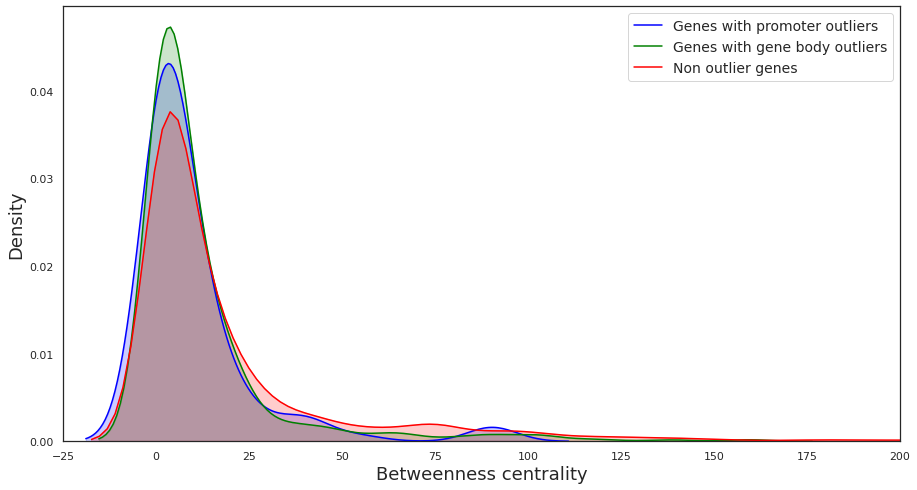

In [8]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style(style='white')
#sns.distplot(df[['all']], hist=False, color="green", label="all")
ax=sns.distplot(df[['prom']], hist=False, color="blue", label="Genes with promoter outliers")
ax=sns.distplot(df[['nprom']], hist=False, color="green", label="Genes with gene body outliers")
ax=sns.distplot(df[['nneighs']], hist=False, color="red", label="Non outlier genes")
plt.xlim(-25,200)
#plt.xlim(-0.0025,0.01)

l1 = ax.lines[0]
l2 = ax.lines[1]
l3 = ax.lines[2]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
x3 = l3.get_xydata()[:,0]
y3 = l3.get_xydata()[:,1]
ax.fill_between(x1,y1, color="blue", alpha=0.2)
ax.fill_between(x2,y2, color="green", alpha=0.2)
ax.fill_between(x3,y3, color="red", alpha=0.2)

#ax.set(xlabel='Betweenness centrality', fontsize=18) # 'Betweenness centrality') #ylabel='Number of neighbors')
plt.xlabel('Number of neighbors', fontsize=18)
plt.ylabel('Density', fontsize=18)

plt.legend(prop={'size': 14})
#plt.savefig("PPI_distributions_cent.pdf", bbox_inches="tight")

[Text(0, 0.5, 'Number of neighbors'), Text(0.5, 0, ' ')]

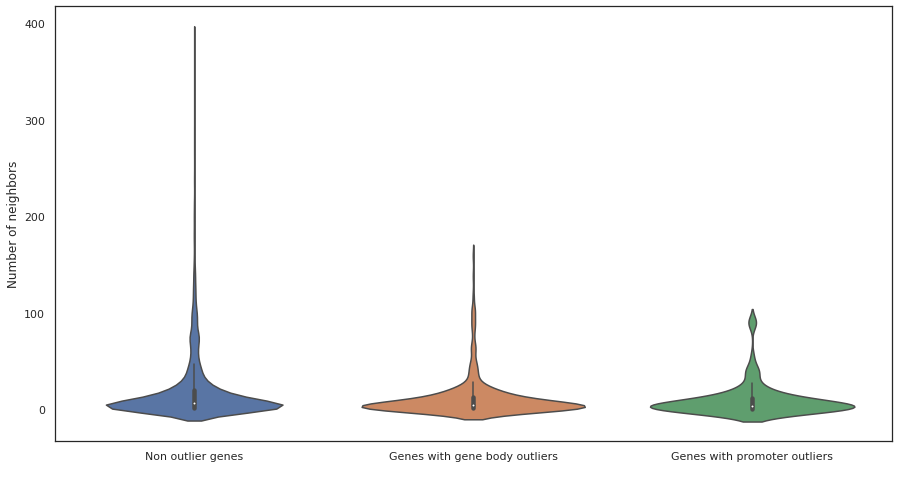

In [9]:
tdf = df.melt(var_name='groups', value_name='vals')
g=sns.violinplot(data=tdf, x="groups", y="vals", order=['nneighs', 'nprom', 'prom'])
g.set_xticklabels(['Non outlier genes', 'Genes with gene body outliers', 'Genes with promoter outliers'])
g.set(xlabel=' ', ylabel='Number of neighbors')
#plt.savefig("PPI_violins.pdf", bbox_inches="tight")

In [10]:
from scipy.stats import mannwhitneyu

In [11]:
my_nprom=df["nprom"].dropna()
my_prom=df["prom"].dropna()
my_all=df["all"].dropna()
my_nneighs=df["nneighs"].dropna()

In [13]:
U1, p = mannwhitneyu(my_all, my_nneighs)
p

1.7235711149033253e-11

# Comparing to previous studies

In [14]:
mlist=["mel_biomin.csv","N_S_diff_expressed.csv","DE_1.csv","DE_2.csv","DE_3.csv","DE_4.csv","all_diff_expressed.csv",
       "related_to_ph_snp.csv","1_7_days_alleles.csv","sig_pH75_onlySPU.txt","sig_pH80_onlySPU.txt", "PMC_enriched.csv","PMC_restricted.csv" ]

In [15]:
def fix_dups(mydf):
  temp=pd.read_csv(mydf, names=["spu"])
  ss=[]
  for s in temp.spu.unique():
    if len(s.split("-"))==2:
      for i in s.split("-"):
        if i.split("_")[0] == "SPU":
          ss.append(i)
    elif len(s.split("-"))>2:
      print("error")
    else:
      ss.append(s)
      
  return(ss)

In [16]:
def anal_mlist(ml, mylist):
  print(ml)

  if (ml == "PMC_enriched.csv") or (ml == "PMC_restricted.csv"):
    temp=pd.read_csv(ml, names=["spu","name"])
    temp['spu'] = temp['spu'].astype(str)
    temp['spu'] = temp['spu'].apply(lambda x: x.zfill(6))
    temp['spu'] = "SPU_" + temp['spu']
    temp=temp.spu.unique()
    #print(temp)

  elif (ml == "sig_pH75_onlySPU.txt") or (ml == "sig_pH80_onlySPU.txt"):
    temp=fix_dups(ml)
    #print(temp)

  else:
    temp=pd.read_csv(ml, names=["spu"])
    temp=temp.spu.unique()
    #print(temp)

  foundlist=[]
  for l in mylist:
    if l in temp:
      foundlist.append(l)

  p=len(temp)/27447
  print("how many I found:",len(foundlist))
  print("how many I expect to find:",len(mylist)*p)
  print(foundlist)

  out=stats.binom_test(len(foundlist), n=len(mylist), p=p, alternative='greater')
  print("pvalue:", out)

In [ ]:
for m in mlist:
  anal_mlist(m,mylist)
